### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 6


### Дисциплина: Методы машинного обучения

##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант 13 
1. Набор данных: `stl10` с изменением разрешения до 48х48 
2. Диапазон классов: 0, 1, 2, 3, 4 
3. Архитектура автокодировщика: MLP 
4. Показатель качества: cреднее квадратичное процентное отклонение (MSPE) для ошибки реконструкции 
5. Показатель качества бинарной классификации: полнота, равная TP/(TP+FN) 

# Выполнение

## 1. Загружаем датасет

In [1]:
import tensorflow_datasets as tfds
import pandas as pd

In [2]:
ds_train, ds_test = tfds.load("stl10", split=["train", "test"])
df_train = tfds.as_dataframe(ds_train)
df_test = tfds.as_dataframe(ds_test)
print(len(df_train), len(df_test))
df_train.head()

2024-05-31 03:38:31.435698: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 03:38:31.438791: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 03:38:31.488596: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 03:38:32.405719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-31 03:38:34.116031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-31 03:38:36.315636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

5000 8000


,image,label
0,"[[[136, 144, 153], [125, 127, 136], [125, 126,...",1
1,"[[[70, 132, 186], [81, 139, 189], [143, 176, 2...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[104, 90, 69], [101, 87, 66], [103, 88, 67],...",3
4,"[[[189, 204, 235], [189, 204, 235], [189, 204,...",9


In [3]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [4]:
rng_state = 1

In [5]:
def sample_images(n, random_state, gray=False):
    for i in df_train.sample(n=n, random_state=random_state)["image"]:
        img = Image.fromarray(i)
        plt.figure()
        if gray:
            # https://stackoverflow.com/a/41266186
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img)

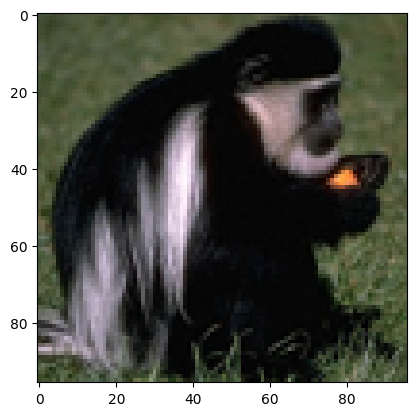

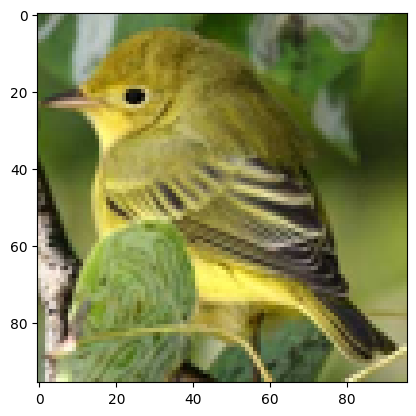

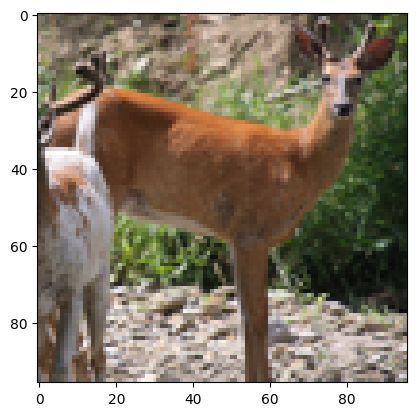

In [6]:
sample_images(3, rng_state)

### 1.1 Изменим размер изображений на 48x48

In [7]:
import numpy as np

In [8]:
WIDTH = 48
HEIGHT = 48

In [9]:
def resize(img):
    img = Image.fromarray(img)
    img = img.resize((WIDTH, HEIGHT))
    return np.asarray(img, np.uint8)

In [10]:
df_train["image"] = df_train["image"].map(resize)
df_test["image"] = df_test["image"].map(resize)

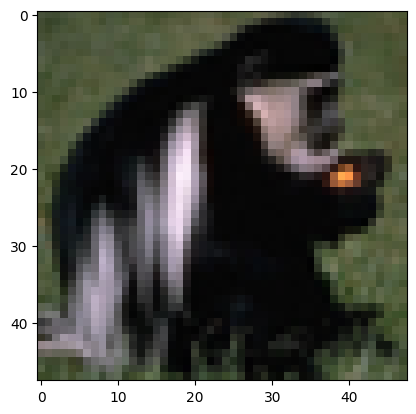

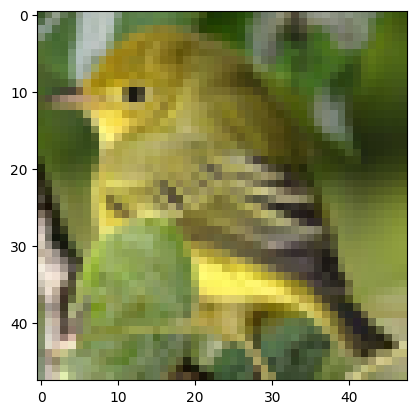

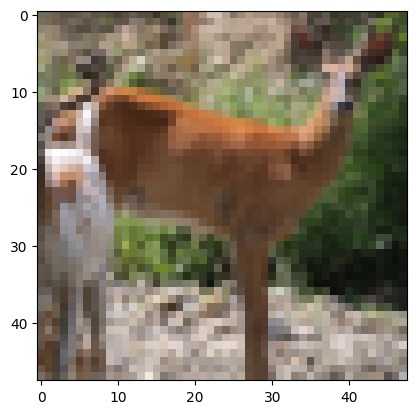

In [11]:
sample_images(3, rng_state)

### 1.2 Перкодируем изображения в одноцветные

In [12]:
def grayscale(img):
    img = Image.fromarray(img)
    img = img.convert("L")
    return np.asarray(img, np.uint8)

In [13]:
df_train["image"] = df_train["image"].map(grayscale)
df_test["image"] = df_test["image"].map(grayscale)

In [14]:
df_train.head()

,image,label
0,"[[127, 112, 111, 130, 137, 114, 119, 132, 127,...",1
1,"[[159, 195, 150, 123, 124, 102, 73, 74, 49, 10...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
3,"[[91, 93, 90, 91, 92, 91, 93, 95, 95, 98, 100,...",3
4,"[[203, 203, 203, 203, 203, 203, 203, 203, 203,...",9


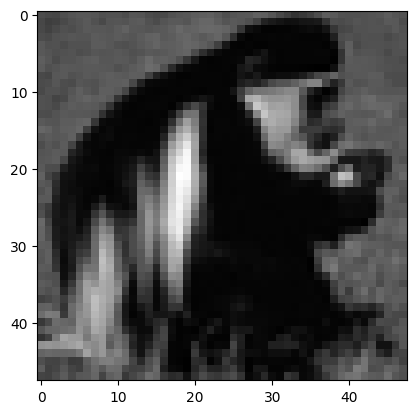

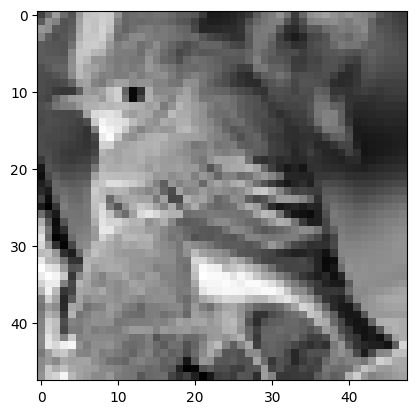

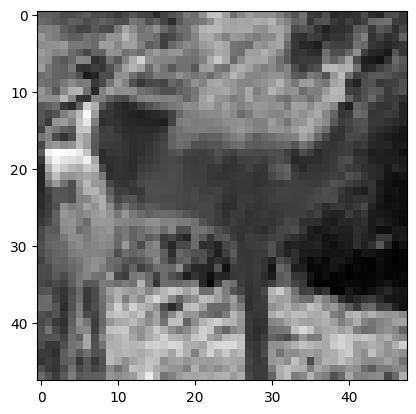

In [15]:
sample_images(3, rng_state, True)

In [16]:
np.unique(np.asarray(df_train["label"]))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
CLASSES = [0, 1, 2, 3, 4]
df_train = df_train[df_train["label"].isin(CLASSES)]
df_test = df_test[df_test["label"].isin(CLASSES)]
print(len(df_train), len(df_test))
df_train.head()

2500 4000


,image,label
0,"[[127, 112, 111, 130, 137, 114, 119, 132, 127,...",1
1,"[[159, 195, 150, 123, 124, 102, 73, 74, 49, 10...",0
3,"[[91, 93, 90, 91, 92, 91, 93, 95, 95, 98, 100,...",3
6,"[[242, 242, 242, 242, 242, 242, 242, 242, 242,...",0
7,"[[3, 2, 3, 3, 3, 22, 35, 1, 8, 18, 3, 3, 4, 3,...",2


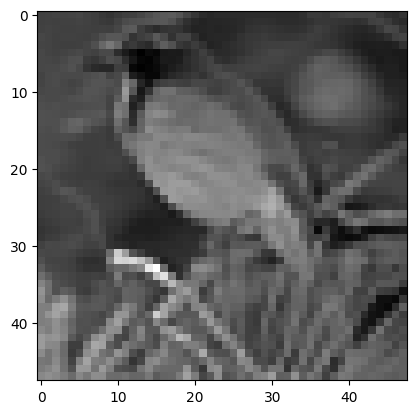

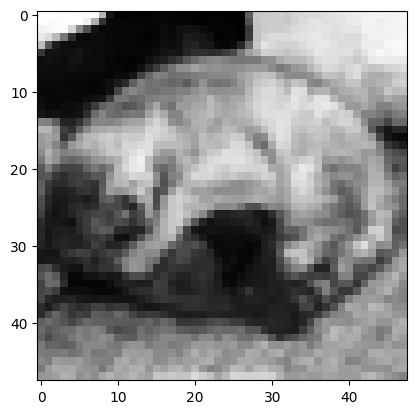

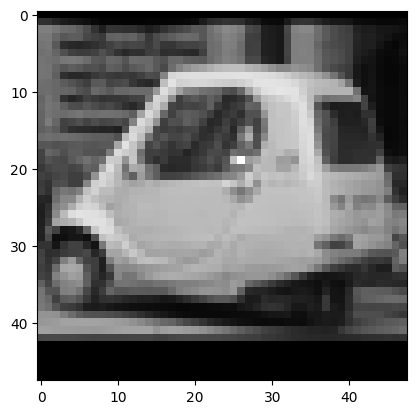

In [18]:
sample_images(3, rng_state, True)

In [19]:
train_images = np.concatenate(df_train["image"].to_numpy()).reshape(len(df_train), WIDTH, HEIGHT)
train_labels = df_train["label"].to_numpy()
train_images, train_labels

(array([[[127, 112, 111, ..., 128, 111, 105],
         [122, 122, 124, ..., 117, 112, 121],
         [137, 142, 124, ..., 114, 119, 130],
         ...,
         [110, 137, 132, ..., 167, 169, 177],
         [128, 127, 128, ..., 154, 173, 168],
         [142, 134, 151, ..., 171, 185, 137]],
 
        [[159, 195, 150, ..., 134, 134, 135],
         [211, 163, 120, ..., 134, 135, 135],
         [151, 127, 122, ..., 135, 134, 135],
         ...,
         [126, 126, 126, ..., 136, 135, 136],
         [125, 126, 126, ..., 135, 135, 135],
         [126, 126, 127, ..., 134, 136, 136]],
 
        [[ 91,  93,  90, ...,  26,  28,  23],
         [ 93,  93,  96, ...,  24,  26,  27],
         [108, 106, 109, ...,  34,  32,  31],
         ...,
         [159, 155, 152, ..., 164, 160, 161],
         [146, 149, 149, ..., 158, 157, 163],
         [ 29,  28,  30, ...,  34,  34,  34]],
 
        ...,
 
        [[  0,   0,   0, ...,   0,   0,   0],
         [  1,   1,   1, ...,   8,   9,   7],
         [  4,

In [20]:
test_images = np.concatenate(df_test["image"].to_numpy()).reshape(len(df_test), WIDTH, HEIGHT)
test_labels = df_test["label"].to_numpy()

## 2. График логарифмического правдоподобия

In [21]:
from scipy.stats import multivariate_normal

def log_likelihood(evals):

    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]  # Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2 

    return ll

In [22]:
train_images.shape

(2500, 48, 48)

In [23]:
shape = train_images.shape
X_train = train_images.reshape(shape[0], shape[1] * shape[2])

In [24]:
X_train.shape

(2500, 2304)

In [25]:
from sklearn.decomposition import PCA

n_samples, n_features = X_train.shape
Kmax = min(n_samples, n_features)

pca = PCA(n_components=Kmax)
X_transformed = pca.fit_transform(X_train)
evals = pca.explained_variance_  # eigenvalues in descending order

ll = log_likelihood(evals)

/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


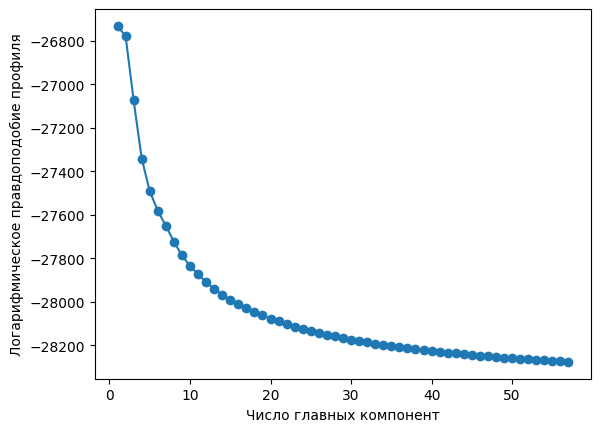

In [26]:
frac = 0.025
components = int(len(ll) * frac)
fig, ax = plt.subplots()
xs = np.arange(1, components + 1)
ys = ll[0:components]
plt.xlabel("Число главных компонент")
plt.ylabel("Логарифмическое правдоподобие профиля")

ax.plot(xs, ys, marker="o")
plt.show()

Размерность латентного пространства???????

In [27]:
latent_dim = np.argmax(ll) + 1
latent_dim

1

## 3. Обучение автокодировщика

### 3.1 Подготовка данных

In [28]:
train_images = train_images.astype('float32') / 255.
test_images  = test_images.astype('float32') / 255.

In [29]:
train_images.shape, test_images.shape

((2500, 48, 48), (4000, 48, 48))

### 3.2 Автокодировщик

In [30]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [31]:
encoder_sizes = [400, 200]
decoder_sizes = encoder_sizes[::-1]

img_in = Input(shape=train_images.shape[1:], name="Input")
flatten = Flatten(name="Flatten")(img_in)

shrinks = [flatten]
for i, n in enumerate(encoder_sizes):
    shrink = Dense(n, activation="relu", name=f"Shrink_{i}")
    shrinks.append(shrink(shrinks[-1]))

bottleneck = Dense(64, activation="relu", name="Bottleneck")(shrinks[-1])

inflaters = [bottleneck]
for i, n in enumerate(decoder_sizes):
    inflater = Dense(n, activation="relu", name=f"Inflate_{i}")
    inflaters.append(inflater(inflaters[-1]))

output = Dense(np.prod(train_images.shape[1:]), activation="sigmoid", name="Ouput")(inflaters[-1])
img_out = Reshape(train_images.shape[1:], name="Reshaped_Output")(output)

autoencoder = Model(img_in, img_out, name="Autoencoder")
encoder = Model(img_in, bottleneck, name="Encoder")
decoder = Model(bottleneck, img_out, name="Decoder")

autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 48, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Shrink_0 (Dense)                │ (None, 400)            │       922,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Shrink_1 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck (Dense)              │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Inflate_0 (Dense)               │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Inflate_1 (Dense)               │ (None, 400)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ouput (Dense)                   │ (None, 2304)           │       923,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reshaped_Output (Reshape)       │ (None, 48, 48)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,032,368 (7.75 MB)

 Trainable params: 2,032,368 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 48, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Shrink_0 (Dense)                │ (None, 400)            │       922,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Shrink_1 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck (Dense)              │ (None, 64)             │        12,864 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,064 (3.87 MB)

 Trainable params: 1,015,064 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_3CLONE             │ (None, 64)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Inflate_0 (Dense)               │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Inflate_1 (Dense)               │ (None, 400)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ouput (Dense)                   │ (None, 2304)           │       923,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reshaped_Output (Reshape)       │ (None, 48, 48)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,304 (3.88 MB)

 Trainable params: 1,017,304 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
autoencoder.compile(optimizer="Adam", loss="binary_crossentropy")

history = autoencoder.fit(
    train_images, train_images,
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_data=(test_images, test_images),
    verbose=1
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.6763 - val_loss: 0.6625
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6504 - val_loss: 0.6322
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6244 - val_loss: 0.6272
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6210 - val_loss: 0.6227
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6179 - val_loss: 0.6194
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6131 - val_loss: 0.6174
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6135 - val_loss: 0.6168
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6107 - val_loss: 0.6183
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6121 - val_loss: 0.6134
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6096 - val_loss: 0.6126
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6060 - val_loss: 0.6106
Epoch 12/100
157/157 ━━━━━━━━━

In [33]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, max(history.history['loss'])])
    plt.xlabel("Эпохи обучения")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.grid(True)

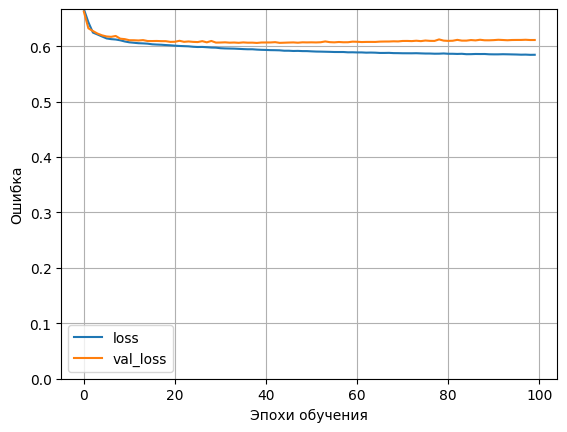

In [34]:
plot_loss(history)

In [35]:
encoded_imgs = encoder.predict(test_images)
decoded_imgs = decoder.predict(encoded_imgs)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [36]:
import matplotlib.pyplot as plt

def image_show(orig_imgs, dec_imgs, fname=None):
    n = 10  # кол-во изображений
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        # исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_imgs[i].reshape(WIDTH, HEIGHT))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # реконструированные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(dec_imgs[i].reshape(WIDTH, HEIGHT))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    if fname:
        fig.savefig(fname)

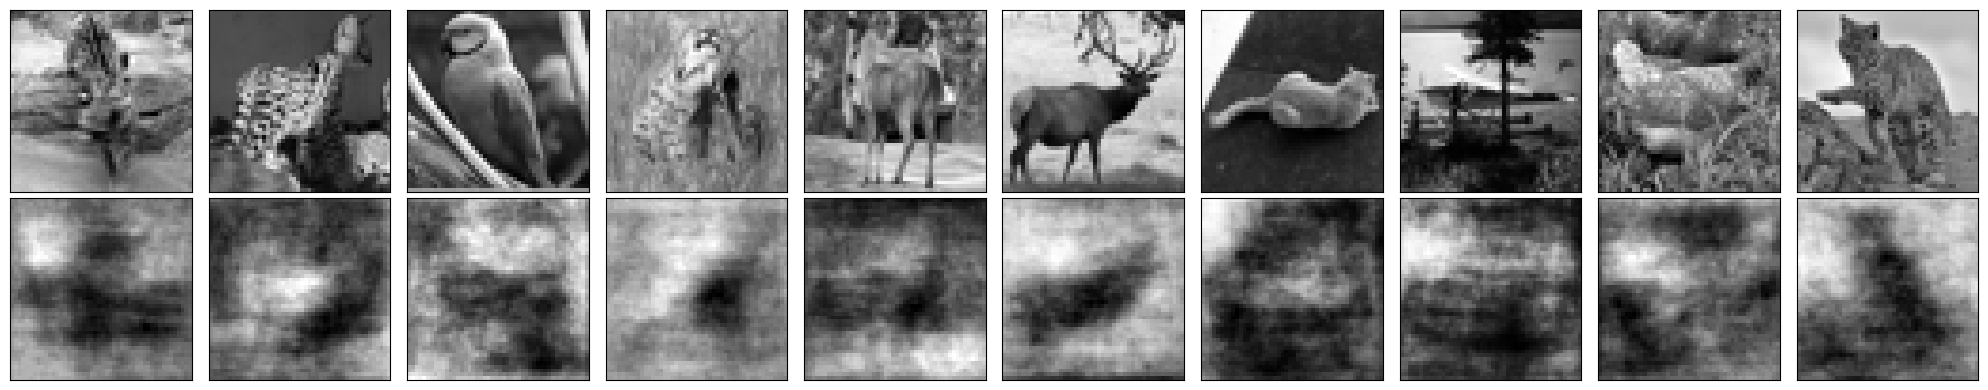

In [37]:
image_show(test_images, decoded_imgs)

## 4. Оценка модели

In [38]:
# # https://stats.stackexchange.com/a/413257
# def mspe(true_values, predicted_values):
#     return np.sum(((predicted_values / true_values - 1) ** 2) / np.prod(true_values.shape))

In [39]:
from sklearn.metrics import mean_squared_error

test_img_flat = test_images.reshape(test_images.shape[0], -1)
pred_img_flat = decoded_imgs.reshape(decoded_imgs.shape[0], -1)
mean_squared_error(test_img_flat, pred_img_flat) * 100

2.1682795137166977

## 5. Визуализация латеннтных признаков

In [40]:
train_imgs_only2 = train_images[np.isin(train_labels, CLASSES[:2])] 
train_labels_only2 = train_labels[np.isin(train_labels, CLASSES[:2])]
test_imgs_only2 = test_images[np.isin(test_labels, CLASSES[:2])]
test_labels_only2 = test_labels[np.isin(test_labels, CLASSES[:2])]

In [41]:
imgs_only2 = np.concatenate((train_imgs_only2, test_imgs_only2), axis=0)
labels_only2 = np.concatenate((train_labels_only2, test_labels_only2), axis=0)

imgs_only2_enc = encoder.predict(imgs_only2)
imgs_only2_enc

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.        , 2.9024627 , 0.49729598, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.0347643 , 2.0936558 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.2293704 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 3.492054  , 0.55451083, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.600706  , 2.6085205 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.3212762 , 1.2838197 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

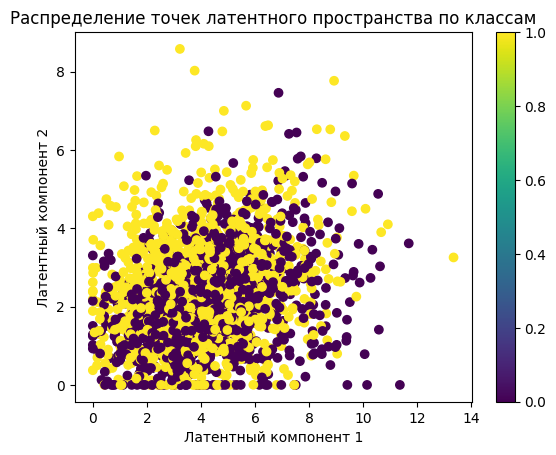

In [42]:
plt.scatter(imgs_only2_enc[:,1], imgs_only2_enc[:,2], c=labels_only2, cmap='viridis')
plt.xlabel("Латентный компонент 1")
plt.ylabel("Латентный компонент 2")
plt.title("Распределение точек латентного пространства по классам")
plt.colorbar()
plt.show()

## 6. KNN-классификация

In [43]:
def flatten(X):
    return np.reshape(X, (X.shape[0], -1))

In [44]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import precision_score
import time
start = time.perf_counter()
knn_full_img = KNeighborsClassifier(n_neighbors=15).fit(flatten(train_imgs_only2), 
                                              train_labels_only2) 
print("Fit: ", time.perf_counter() - start)

accuracy = knn_full_img.score(flatten(test_imgs_only2), test_labels_only2) 
print ("Accuracy KNN по всему изображению: ", accuracy)

pred = knn_full_img.predict(flatten(test_imgs_only2))
precision = precision_score(test_labels_only2, pred)
print ("Полнота KNN по всему изображению: ", precision)

Fit:  0.001667417000135174
Accuracy KNN по всему изображению:  0.646875
Полнота KNN по всему изображению:  0.8706624605678234


In [45]:
start = time.perf_counter()
latent_imgs = encoder.predict(train_imgs_only2)
knn_latent_img = KNeighborsClassifier(n_neighbors=15).fit(latent_imgs, 
                                              train_labels_only2) 
print("Fit: ", time.perf_counter() - start)

latent_imgs_test = encoder.predict(test_imgs_only2)
accuracy = knn_latent_img.score(latent_imgs_test, test_labels_only2) 
print ("Accuracy KNN по латентному изображению: ", accuracy)

pred = knn_latent_img.predict(latent_imgs_test)
precision = precision_score(test_labels_only2, pred)
print ("Полнота KNN по латентному изображению: ", precision)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fit:  0.11339767800018308
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy KNN по латентному изображению:  0.78
Полнота KNN по латентному изображению:  0.8404255319148937


## 7. ROC-кривые для классификаторов

In [46]:
bin_test_labels = (test_labels_only2 == 0).astype(int)

prob_full = knn_full_img.predict_proba(flatten(test_imgs_only2))
prob_latent = knn_latent_img.predict_proba(latent_imgs_test)

prob_full = prob_full[:, 0]
prob_latent = prob_latent[:, 0]

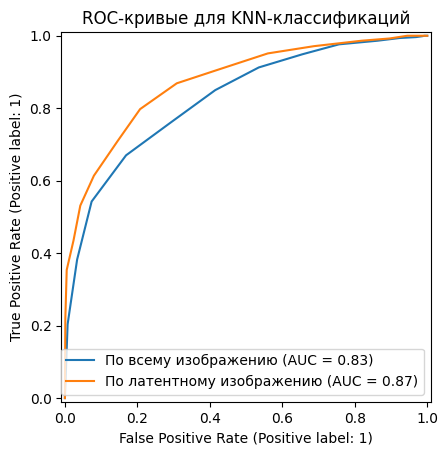

In [47]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    bin_test_labels,
    prob_full,
    name="По всему изображению",
    ax=ax
)

RocCurveDisplay.from_predictions(
    bin_test_labels,
    prob_latent,
    name="По латентному изображению",
    ax=ax
)

_ = ax.set(
    title="ROC-кривые для KNN-классификаций",
)


## 8. Границы принятия решений

In [48]:
all_latent_imgs = encoder.predict(imgs_only2)
avg_latent = np.mean(all_latent_imgs, axis=0)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


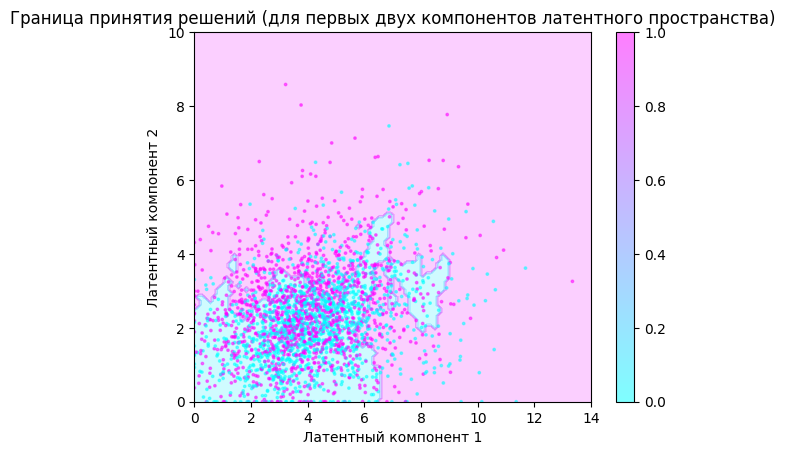

In [53]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = plt.subplots()
x_low = 0
x_high = 14
y_low = 0
y_high = 10

xx0,xx1 = np.meshgrid(np.linspace(x_low, x_high, 100), np.linspace(y_low, y_high, 100))

predict_points = []
for x0, x1 in zip(xx0.ravel(), xx1.ravel()):
    to_predict = np.copy(avg_latent)
    to_predict[1] = x0
    to_predict[2] = x1
    predict_points.append(to_predict)


Z = knn_latent_img.predict(predict_points)


display = DecisionBoundaryDisplay(
    xx0=xx0,xx1=xx1,response=Z.reshape(xx0.shape),
)
display.plot(ax=ax, cmap='cool', alpha=0.2)

plt.scatter(imgs_only2_enc[:,1], imgs_only2_enc[:,2], c=labels_only2, cmap='cool', alpha=0.5, s=3)
plt.xlabel("Латентный компонент 1")
plt.ylabel("Латентный компонент 2")
plt.title("Граница принятия решений (для первых двух компонентов латентного пространства)")
plt.colorbar()

## 9. Ошибки реконструирования

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[0.02093991 0.01121302 0.01836176 ... 0.01085369 0.0177615  0.01864485]


Text(0.5, 1.0, 'Распределение ошибки реструктурирования')

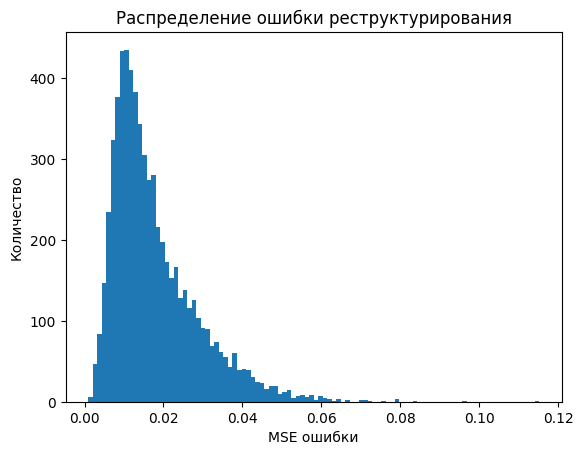

In [50]:
all_imgs = np.concatenate((train_images, test_images), axis=0)
all_imgs_encoded = autoencoder.predict(all_imgs)

# for each image, calculate its reconstruction error
reconstruction_errors = np.mean(np.square(all_imgs - all_imgs_encoded), axis=(1,2))

print(reconstruction_errors)
# plot the reconstruction error distribution
plt.hist(reconstruction_errors, bins=100)
plt.xlabel("MSE ошибки")
plt.ylabel("Количество")
plt.title("Распределение ошибки реструктурирования")

Text(0.5, 1.0, 'Минимальная ошибка: \n0.00092921656')

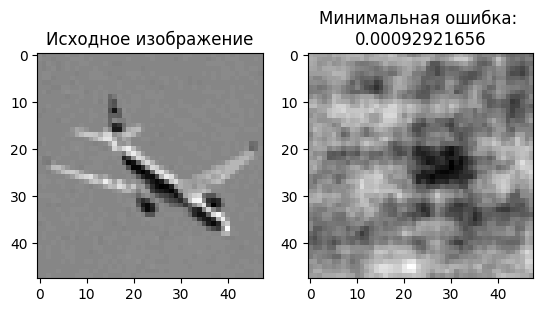

In [51]:
min_index = np.argmin(reconstruction_errors)
min_error = reconstruction_errors[min_index]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(all_imgs[min_index])
ax1.set_title("Исходное изображение")
ax2.imshow(all_imgs_encoded[min_index])
ax2.set_title("Минимальная ошибка: \n" + str(min_error))

Text(0.5, 1.0, 'Максимальная ошибка: \n0.1151919')

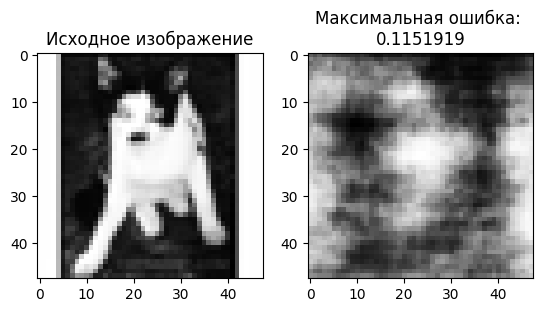

In [52]:
max_index = np.argmax(reconstruction_errors)
max_error = reconstruction_errors[max_index]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(all_imgs[max_index])
ax1.set_title("Исходное изображение")
ax2.imshow(all_imgs_encoded[max_index])
ax2.set_title("Максимальная ошибка: \n" + str(max_error))